## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load 2 first componant

In [2]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/2firstcomponent.npy', allow_pickle=True)
times = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/readyforwPCA_epoc.npy')

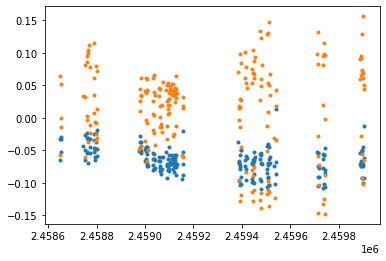

In [3]:
plt.plot(times, eigen2vectors[0], '.')
plt.plot(times, eigen2vectors[1], '.')
plt.show()

## Periodograms
### 1st component

Peak frequency = 
4188.511057387417


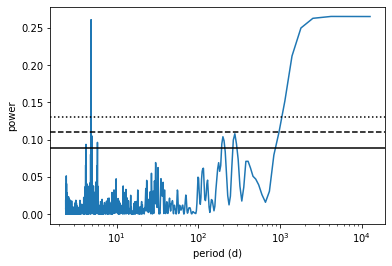

In [4]:
frequency, power = LombScargle(times, eigen2vectors[0]).autopower()
plt.figure(2)
plt.plot(1/frequency, power)
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[0])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 2nd component

Peak frequency = 
4.872250163692226


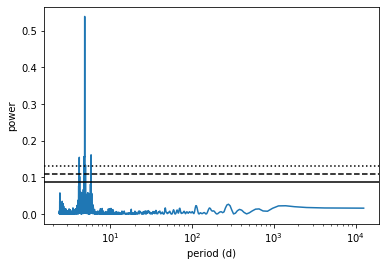

In [5]:
frequency, power = LombScargle(times, eigen2vectors[1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power)
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

## First component GP 

In [6]:
print(2*(np.max(eigen2vectors[0])- np.min(eigen2vectors[0])))
print(np.std(eigen2vectors[0]))
print(10*(np.max(times)-np.min(times)))


0.24633063548006165
0.020687797217148286
12565.53317216225


In [7]:
#Priors
n_eta1 = ModifiedLogUniform(0.02, 0.25)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.02, 0.25)

In [8]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [9]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0], yerr = 1e-12 * np.identity(times.size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [10]:
ndim = priors().size 
nwalkers = 2*ndim

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [07:17<00:00, 22.85it/s]


State([[4.33567326e-02 1.40723087e+02 4.86113233e+00 1.26215015e+00
  7.75175249e-03]
 [2.68822503e-02 1.09356831e+02 4.86170391e+00 1.11248783e+00
  8.18196313e-03]
 [2.13155598e-02 1.04401899e+02 4.85807377e+00 9.92582197e-01
  7.80167377e-03]
 [2.43129134e-02 9.12790764e+01 4.84655076e+00 8.94186276e-01
  7.74550878e-03]
 [1.82793743e-02 9.53039782e+01 4.86285673e+00 8.55132024e-01
  7.00465061e-03]
 [2.25483999e-02 7.97070832e+01 4.86163313e+00 9.99814522e-01
  7.12319013e-03]
 [2.96144245e-02 1.21720447e+02 4.86538242e+00 1.16121724e+00
  7.57540922e-03]
 [2.48122526e-02 1.17695437e+02 4.86130924e+00 1.11713873e+00
  8.16263995e-03]
 [4.57765705e-02 1.60200515e+02 4.86767522e+00 1.66963661e+00
  8.22786080e-03]
 [7.88008510e-02 1.51465596e+03 4.75755336e+00 2.02299189e+00
  1.68946687e-02]], log_prob=[644.63609142 650.54617873 650.59241518 646.60013078 648.30765764
 649.37866239 651.15176219 650.92845362 643.86077044 534.69660223], blobs=None, random_state=('MT19937', array([ 5148

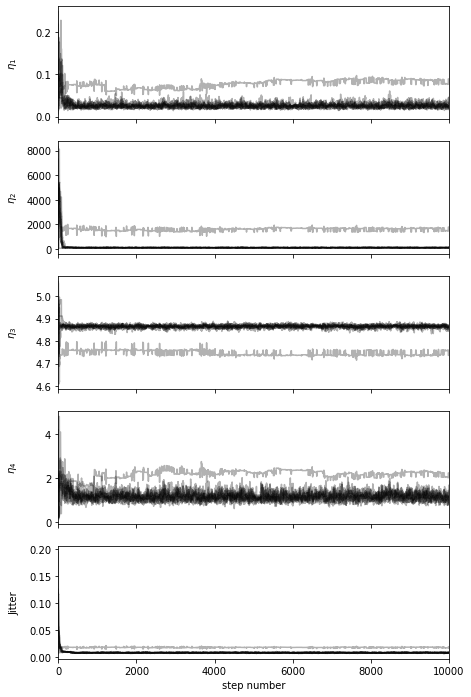

In [12]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

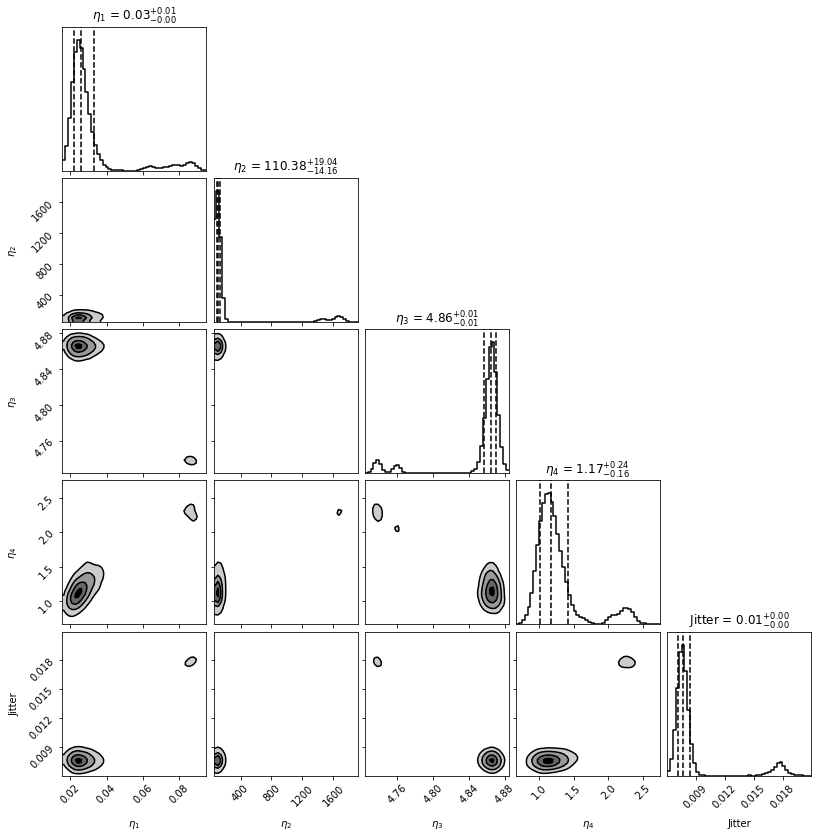

In [13]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False)
plt.show()

In [14]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0],yerr = 1e-12 * np.identity(times.size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

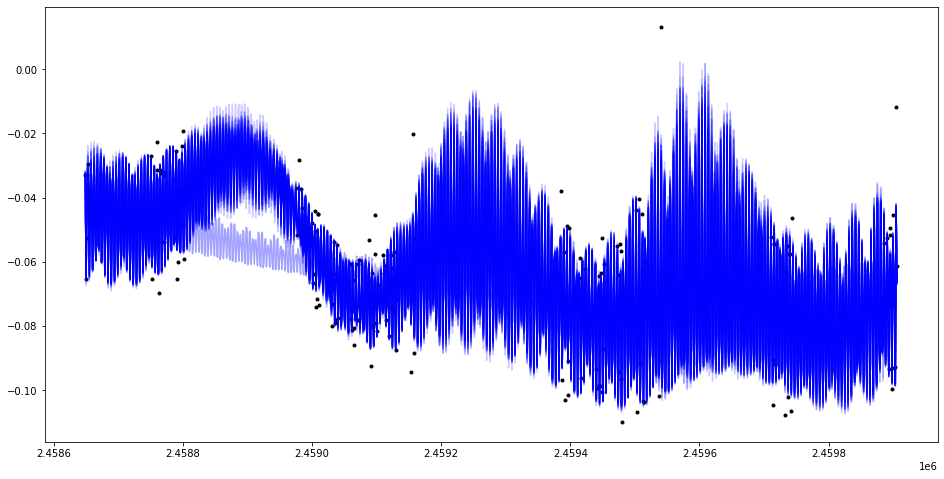

In [15]:
plt.figure(figsize=(16, 8))

plt.plot(times, eigen2vectors[0],'k.')
tplot = np.linspace(np.min(times), np.max(times), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
plt.show()

## 2nd component GP

In [16]:
print(2*(np.max(eigen2vectors[1])- np.min(eigen2vectors[1])))
print(np.std(eigen2vectors[1]))
print(10*(np.max(times)-np.min(times)))

0.6080053951959095
0.06720146635109973
12565.53317216225


In [17]:
#Priors
n_eta1 = ModifiedLogUniform(0.06, 0.6)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.06, 0.6)

In [18]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [19]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[1], yerr = 1e-12 * np.identity(times.size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [20]:
ndim = priors().size 
nwalkers = 2*ndim

In [21]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [07:58<00:00, 20.90it/s]


State([[5.53157806e-02 1.16176073e+02 4.85942471e+00 9.01803143e-01
  1.53479550e-02]
 [5.58808878e-02 1.14954938e+02 4.86306210e+00 8.47239676e-01
  1.27688978e-02]
 [6.00280392e-02 1.06045065e+02 4.87020866e+00 8.83369677e-01
  1.23993819e-02]
 [7.57257917e-02 9.56199240e+01 4.86105558e+00 1.05101272e+00
  1.51459757e-02]
 [6.57296632e-02 8.15292701e+01 4.87101615e+00 9.18217682e-01
  1.30622760e-02]
 [7.64600137e-02 6.93794310e+01 4.86296547e+00 9.30126212e-01
  1.25583590e-02]
 [5.90236910e-02 1.05832663e+02 4.86476381e+00 8.46744146e-01
  1.39682051e-02]
 [6.41416230e-02 1.18843898e+02 4.86121623e+00 8.73764800e-01
  1.34065556e-02]
 [6.17841502e-02 1.19236745e+02 4.86676991e+00 8.82590090e-01
  1.38603730e-02]
 [6.31225193e-02 1.14750057e+02 4.86612888e+00 9.22598313e-01
  1.48832378e-02]], log_prob=[493.52623624 495.41791856 494.03119801 491.39187848 493.48742654
 490.36434043 496.12576703 496.05205191 495.62874068 495.05904892], blobs=None, random_state=('MT19937', array([ 5148

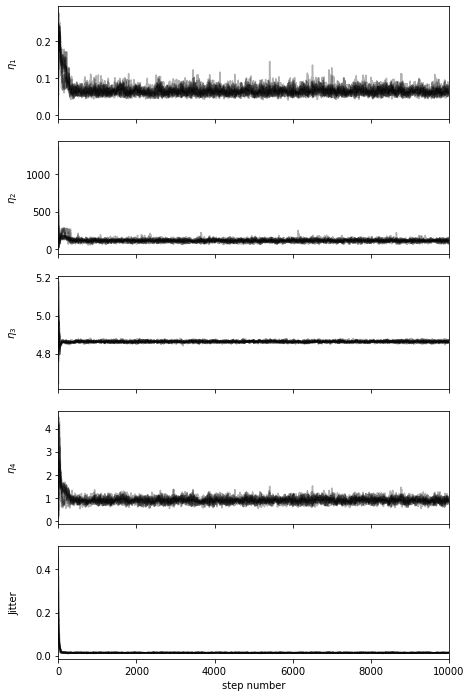

In [22]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

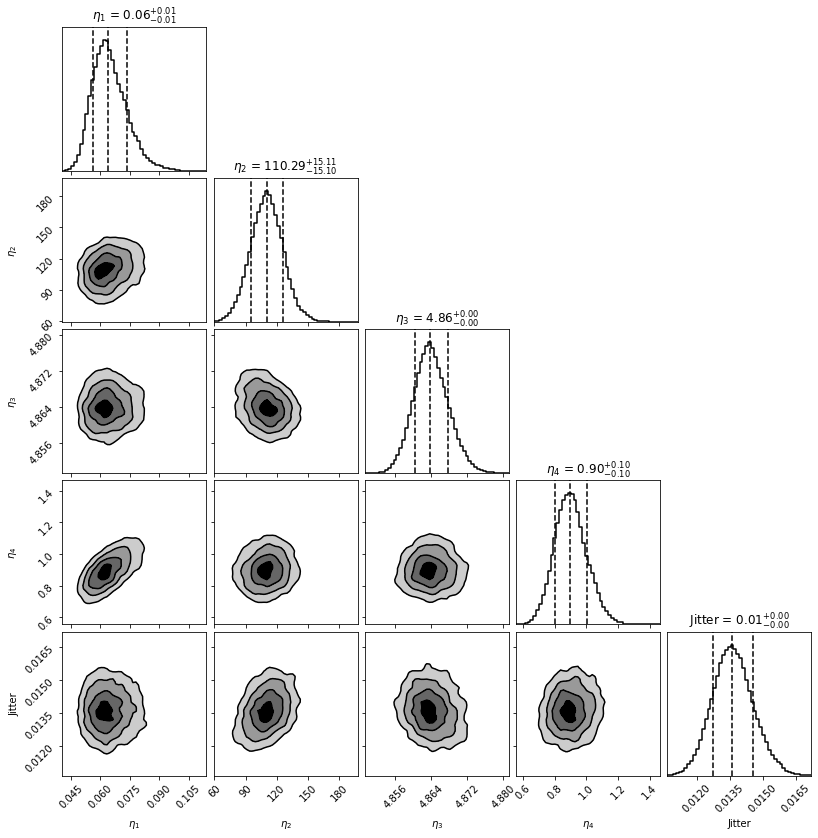

In [23]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False)
plt.show()

In [24]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[1],yerr = 1e-12 * np.identity(times.size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

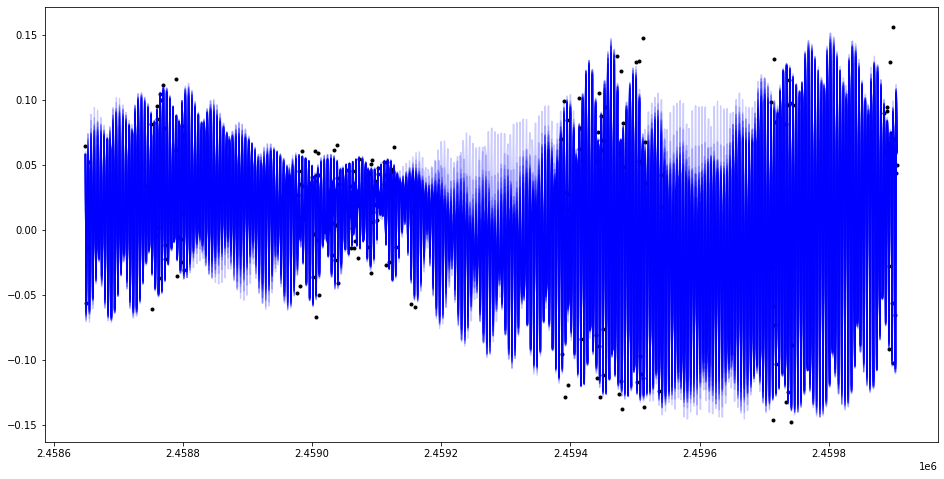

In [25]:
plt.figure(figsize=(16, 8))

plt.plot(times, eigen2vectors[1],'k.')
tplot = np.linspace(np.min(times), np.max(times), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
plt.show()